In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
import random
import sklearn
from sklearn import ensemble
from itertools import chain
from typing import TextIO
import re
import seaborn as sns
from scipy import stats

In [2]:
genes_filter_1 =['RPS6', 'PRPF19', 'RPL34', 'Hsp10', 'POLR2I', 'EIF5B', 'RPL31',
       'RPS3A', 'CSE1L', 'XAB2', 'PSMD7', 'SUPT6H', 'EEF2', 'RPS11',
       'SNRPD2', 'RPL37', 'SF3B3', 'DDX51', 'RPL7', 'RPS9', 'KARS',
       'SF3A1', 'RPL32', 'PSMB2', 'RPS7', 'EIF4A3', 'U2AF1', 'PSMA1',
       'PHB', 'POLR2D', 'RPSA', 'RPL23A', 'NUP93', 'AQR', 'RPA2',
       'SUPT5H', 'RPL6', 'RPS13', 'SF3B2', 'RPS27A', 'PRPF31', 'COPZ1',
       'RPS4X', 'PSMD1', 'RPS14', 'NUP98', 'USP39', 'CDC5L', 'RPL5',
       'PHB2', 'RPS15A', 'RPS3', 'ARCN1', 'COPS6']

base_positions = {
    'A': 0,
    'T': 1,
    'C': 2,
    'G': 3,
    0: 'A',
    1: 'T',
    2: 'C',
    3: 'G',
}

In [3]:
#start here, read full dataset features
dataframe = pd.read_csv('../data/integrated_guide_feature_filtered_f24_mismatch3_all_features.csv')
num_examples = len(dataframe['gene'].values)

#GC content in the window 17-23
gc_content_win = []
for guide in dataframe['guide'].values:
    gc_num = (guide[16:23].upper()).count('G') + (guide[16:23].upper()).count('C')
    gc_content_win.append(gc_num/7)
    
dataframe['GC_content_mid'] = gc_content_win

## correlation of GC content with guide/target unfolding energy

<Figure size 432x288 with 0 Axes>

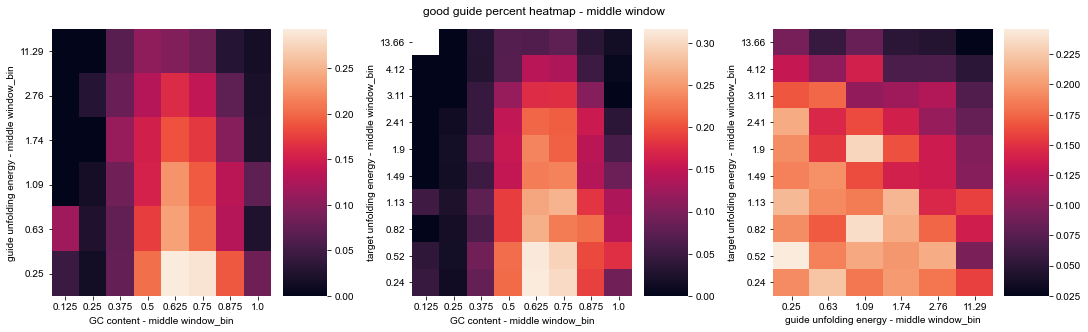

In [5]:
#good guide percent, bin by feature percentile
flist = ['GC_content_mid','linearfold_vals_7win','target unfold energy_7win']
fname_list = ['GC content - middle window','guide unfolding energy - middle window','target unfolding energy - middle window']
cuts = pd.DataFrame({fname_list[i] + '_bin' : pd.qcut(dataframe[flist[i]], q=20,
                              duplicates='drop') for i in range(len(flist))})
cuts['GC content - middle window_bin'] = pd.cut(dataframe['GC_content_mid'],
                                  bins=8)

plt.clf()
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

fig, ax = plt.subplots(1,3,figsize=(15,4.5),constrained_layout=True)
fig.suptitle('good guide percent heatmap - middle window')
for i in range(2): 
    for j in range(i+1,3):
        means = dataframe.join(cuts).groupby([(fname_list[i] + '_bin'),(fname_list[j] + '_bin')])['binary_relative_ratio_075f'].mean()
        means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.
        # Reverse the order of the rows as the heatmap will print from top to bottom.
        means = means.iloc[::-1]
        if i != 0:
            p=2
        else:
            p=j-1
        #use the right bin value as label
        h = sns.heatmap(means,xticklabels = means.columns.map(lambda x : x.right),
                            yticklabels = means.index.map(lambda x : x.right),ax=ax[p])
        h.set_yticklabels(h.get_yticklabels(), rotation = 0)
        #plt.yticks(rotation=0) 
plt.savefig(fname='../a_figures/nmer_middle_heatmap.svg')

<ipython-input-5-66cad87507ba>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gf_bin['GC content - middle window'] = pd.cut(gf_bin['GC_content_mid'],
<ipython-input-5-66cad87507ba>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gf_bin['GC content - middle window'] = pd.cut(gf_bin['GC_content_mid'],
<ipython-input-5-66cad87507ba>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

<Figure size 432x288 with 0 Axes>

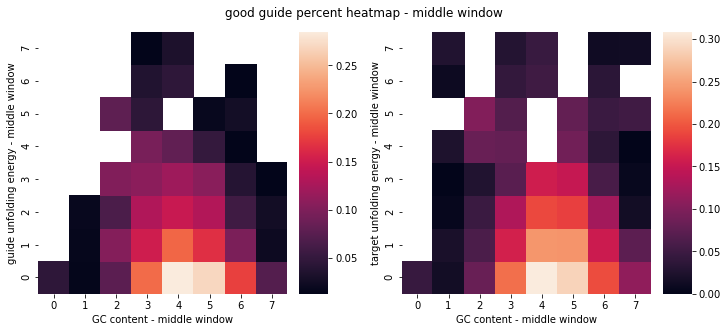

In [5]:
#good guide label heatmap, bin by feature value
plt.clf()
fig, ax = plt.subplots(1, 2,figsize=(10,4.5),constrained_layout=True)
fig.suptitle('good guide percent heatmap - middle window')

#guide free energy
df_all = pd.DataFrame(columns = np.arange(8), 
                   index = np.arange(8))

for gf in range(8): #bin data based on guide free energy
    if gf<7:
        gf_bin = dataframe[(dataframe['linearfold_vals_7win']< (gf+1)) & (dataframe['linearfold_vals_7win'] >= gf)]
    else:
        gf_bin = dataframe[dataframe['linearfold_vals_7win']>= gf] #last bin include all values >= max(gf)
    gf_bin['GC content - middle window'] = pd.cut(gf_bin['GC_content_mid'],
                                  bins=8,labels=list(range(8)))
    gc_list = [] #good guide percent at each GC_content
    for i in range(8):
        grid = gf_bin[gf_bin['GC content - middle window']==i]
        #if grid.empty == False:
        if len(grid)>50:
            gc_list.append(np.mean(grid['binary_relative_ratio_075f'].values))
        else:
            gc_list.append(None)
    df_all.loc[gf] = gc_list
    
hp = sns.heatmap(df_all.astype(float),ax=ax[0])
hp.invert_yaxis()
ax[0].set(xlabel ='GC content - middle window', ylabel ='guide unfolding energy - middle window')

#target unfolding energy
df_all = pd.DataFrame(columns = np.arange(8), 
                   index = np.arange(8))

for tg in range(8): #bin data based on target unfolding energy
    if tg<7:
        tg_bin = dataframe[(dataframe['target unfold energy_7win']< (tg+1)) & (dataframe['target unfold energy_7win'] >= tg)]
    else:
        tg_bin = dataframe[dataframe['target unfold energy_7win'] >= tg] #last bin include all values >= max(tg)
    tg_bin['GC content - middle window'] = pd.cut(tg_bin['GC_content_mid'],
                                  bins=8,labels=list(range(8)))
    gc_list = [] #good guide percent at each GC_content
    for i in range(8):
        grid = tg_bin[tg_bin['GC content - middle window']==i]
        #if grid.empty == False:
        if len(grid)>50:
            gc_list.append(np.mean(grid['binary_relative_ratio_075f'].values))
        else:
            gc_list.append(None)
    df_all.loc[tg] = gc_list

hp = sns.heatmap(df_all.astype(float),ax=ax[1])
hp.invert_yaxis()
ax[1].set(xlabel ='GC content - middle window', ylabel ='target unfolding energy - middle window')
plt.savefig('../a_figures/gc_unfolding_goodguide_label_heatmap_mid_win.svg', format="svg")

<ipython-input-6-ceefee7b2fbd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gf_bin['GC_content_bin'] = pd.cut(gf_bin['GC_content'],
<ipython-input-6-ceefee7b2fbd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gf_bin['GC_content_bin'] = pd.cut(gf_bin['GC_content'],
<ipython-input-6-ceefee7b2fbd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

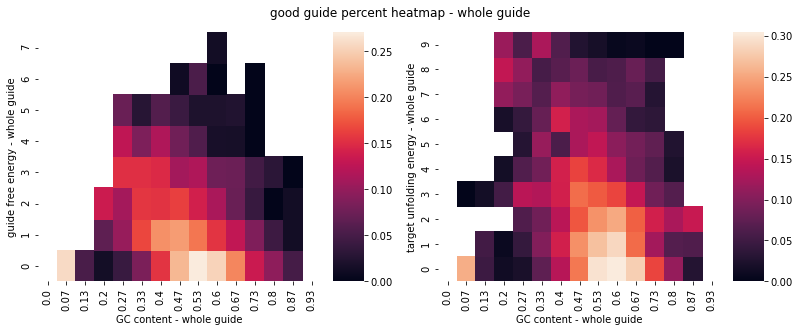

In [6]:
#whole guide, good guide label heatmap
fig, ax = plt.subplots(1, 2,figsize=(11,4.5),constrained_layout=True)
fig.suptitle('good guide percent heatmap - whole guide')

df_all = pd.DataFrame(columns = np.around(np.arange(15)/15,2), 
                   index = np.arange(8))

for gf in range(8): #bin data based on guide free energy
    if gf<7:
        gf_bin = dataframe[(dataframe['linearfold_vals']< (gf+1)) & (dataframe['linearfold_vals'] >= gf)]
    else:
        gf_bin = dataframe[dataframe['linearfold_vals']>= gf] #last bin include all values >= max(gf)
    gf_bin['GC_content_bin'] = pd.cut(gf_bin['GC_content'],
                                  bins=15,labels=list(range(15)))
    gc_list = [] # good guide percent at each GC_content
    
    for i in range(15):
        grid = gf_bin[gf_bin['GC_content_bin']==i]
        #if grid.empty == False:
        if len(grid)> 50: #more than 50 guides
            gc_list.append(np.mean(grid['binary_relative_ratio_075f'].values))
        else:
            gc_list.append(None)
    df_all.loc[gf] = gc_list
    
hp = sns.heatmap(df_all.astype(float),ax=ax[0])
#hp = sns.heatmap(df_all.astype(float),cmap="crest")
hp.invert_yaxis()
#hp.set_xticklabels(hp.get_xticklabels(), rotation=60, horizontalalignment='right')
ax[0].set(xlabel ='GC content - whole guide', ylabel ='guide free energy - whole guide')

#target unfolding energy
df_all = pd.DataFrame(columns = np.around(np.arange(15)/15,2), 
                   index = np.arange(10))

for tg in range(10): #bin data based on target unfolding energy
    if tg<9:
        tg_bin = dataframe[(dataframe['target unfold energy']< (tg+1)) & (dataframe['target unfold energy'] >= tg)]
    else:
        tg_bin = dataframe[dataframe['target unfold energy'] >= tg] #last bin include all values >= max(tg)
    tg_bin['GC_content_bin'] = pd.cut(tg_bin['GC_content'],
                                  bins=15,labels=list(range(15)))
    gc_list = [] #medium of guide relative ratio at each GC_content
    for i in range(15):
        grid = tg_bin[tg_bin['GC_content_bin']==i]
        #if grid.empty == False:
        if len(grid)>50:
            gc_list.append(np.mean(grid['binary_relative_ratio_075f'].values))
        else:
            gc_list.append(None)
    df_all.loc[tg] = gc_list

hp = sns.heatmap(df_all.astype(float),ax=ax[1])
hp.invert_yaxis()
ax[1].set(xlabel ='GC content - whole guide', ylabel ='target unfolding energy - whole guide')
plt.savefig('../a_figures/gc_unfolding_goodguide_label_heatmap_whole_guide.svg', format="svg")

<Figure size 432x288 with 0 Axes>

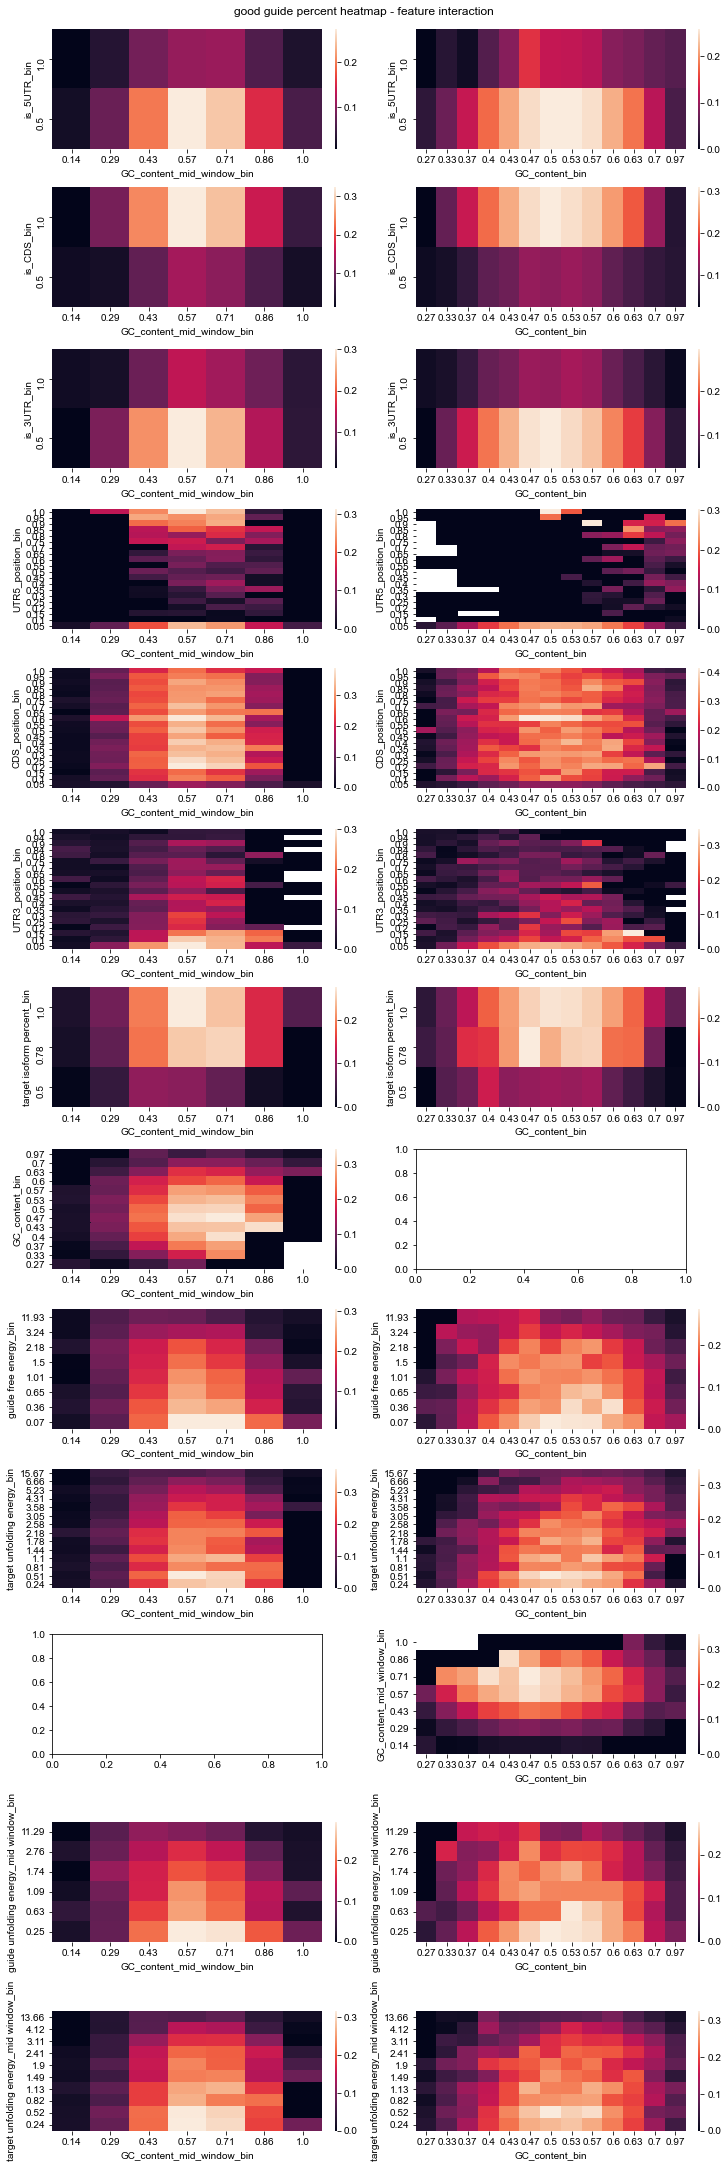

In [37]:
# GC content mid with all feature correlation
features = ['is_5UTR','is_CDS','is_3UTR','UTR5_position','CDS_position','UTR3_position','refseq_target_transcript_percent','linearfold_dr_flag','GC_content','linearfold_vals','target unfold energy',
            'GC_content_mid','linearfold_vals_7win','target unfold energy_7win']
feature_name = ['is_5UTR','is_CDS','is_3UTR','UTR5_position','CDS_position','UTR3_position','target isoform percent','direct repeat disruption','GC_content','guide free energy','target unfolding energy',
                'GC_content_mid_window','guide unfolding energy_mid window','target unfolding energy_mid window']

cuts = pd.DataFrame({str(feature_name[i]) + '_bin' : pd.qcut(dataframe[features[i]], q=20,
                              duplicates='drop') for i in range(6,len(features)) if i!=7})
for i in [3,4,5]: #position floats
    dataframe[str(feature_name[i]) + '_bin'] = pd.cut(dataframe[features[i]],bins=20)
for i in [0,1,2,7]: #flags
    dataframe[str(feature_name[i]) + '_bin'] = pd.cut(dataframe[features[i]],bins=2)

plt.clf()
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

fig, ax = plt.subplots(13,2,figsize=(10,30),constrained_layout=True)
fig.suptitle('good guide percent heatmap - feature interaction')
#for i in range(8,len(features)): # non-pos features
gc_list = ['GC_content_mid_window','GC_content']
for i in range(2): # mid GC content or whole guide GC content
    for j in range(len(features)):
        if j==7 or gc_list[i]==feature_name[j]:
            continue
        else:
            fx = gc_list[i] + '_bin'
            fy = feature_name[j] + '_bin'
            grouped = dataframe.join(cuts).groupby([fx,fy])
            size_g = grouped.size()
            size_g = size_g.unstack(level = 0) # Use level 0 to put 0Bin as columns.
            size_g = size_g.mask(size_g <= 50)
            size_g = size_g.mask(size_g > 50, 1)
            #grouped.filter(lambda x: len(x) > 50)
            means = grouped['binary_relative_ratio_075f'].mean()
            means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.
            # Reverse the order of the rows as the heatmap will print from top to bottom.
            means = means.multiply(size_g)
            means = means.iloc[::-1]
            px= j
            if j>7:
                px = j-1
            #use the right bin value as label
            sns.heatmap(means,xticklabels = means.columns.map(lambda x : round(x.right,2)),
                                yticklabels = means.index.map(lambda x : round(x.right,2)),ax=ax[px,i])

#plt.savefig('../a_figures/feature_interaction1.svg')

In [36]:
size_g

GC_content_bin,"(-0.001, 0.267]","(0.267, 0.333]","(0.333, 0.367]","(0.367, 0.4]","(0.4, 0.433]","(0.433, 0.467]","(0.467, 0.5]","(0.5, 0.533]","(0.533, 0.567]","(0.567, 0.6]","(0.6, 0.633]","(0.633, 0.7]","(0.7, 0.967]"
target unfolding energy_mid window_bin,,,,,,,,,,,,,
"(-0.001, 0.24]",0,0,0,0,0,0,0,0,0,0,0,0,0
"(0.24, 0.52]",0,0,0,0,0,0,0,0,0,0,0,0,0
"(0.52, 0.82]",0,0,0,0,0,0,0,0,0,0,0,0,0
"(0.82, 1.13]",0,0,0,0,0,0,0,0,0,0,0,0,0
"(1.13, 1.49]",0,0,0,0,0,0,0,0,0,0,0,0,0
"(1.49, 1.9]",0,0,0,0,0,0,0,0,0,0,0,0,0
"(1.9, 2.41]",0,0,0,0,0,0,0,0,0,0,0,0,0
"(2.41, 3.11]",0,0,0,0,0,0,0,0,0,0,0,0,0
"(3.11, 4.12]",0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
gc_mid1 = dataframe[dataframe['GC_content_mid']>=0.85]
print(len(gc_mid1))
len(gc_mid1[(gc_mid1['GC_content']>= 0.36) &(gc_mid1['GC_content']<= 0.41)])
#0.37 0.4
#0.43 0.47

6996


45

## favored motif

In [4]:
# base motif: 17[G,C], 18[G,C], 19[C,G], 20[C], 21[C], 22[G,C], 23[G]
motif_dic = {}
p17=p18=p19=p22=['C','G']
p20=p21=['C']
p23=['G']
for b17 in p17:
    for b18 in p18:
        for b19 in p19:
            for b20 in p20:
                for b21 in p21:
                    for b22 in p22:
                        for b23 in p23:
                            motif = b17+b18+b19+b20+b21+b22+b23
                            motif_dic[motif] = motif
                            
guide_with_good_motif = {} #key: guide, value: list of gene, pos, relative ratio
for index, row in dataframe.iterrows():
    guide = row['guide'].upper()
    if guide[16:23] in motif_dic:
        guide_with_good_motif[row['guide']]=[row['gene'],row['pos'],1-row['relative_ratio'],row['binary_relative_ratio_075f']]
len(guide_with_good_motif)                      

94

In [5]:
df_guide_motif = pd.DataFrame.from_dict(guide_with_good_motif, orient='index',columns=['gene', 'pos', 'relative_ratio', 'binary_relative_ratio'])
#df_guide_motif['binary_relative_ratio'].values
goodg = np.count_nonzero(df_guide_motif['binary_relative_ratio'].values)
print(goodg)
print(goodg/len(df_guide_motif))

7
0.07446808510638298


In [6]:
# 1 to 3 A/T substitute on the basic motif
motif_1sub_dic = {}
motif_2sub_dic = {}
motif_3sub_dic = {}

#sub 1
for m in motif_dic.keys():
    for i in range(7):
        ms1 = list(m)
        ms1[i] = 'A'
        ms1 = "".join(ms1)
        motif_1sub_dic[ms1]=ms1
        ms2 = list(m)
        ms2[i] = 'T'
        ms2 = "".join(ms2)
        motif_1sub_dic[ms2]=ms2
        
print(len(motif_1sub_dic))

#sub 2
for m in motif_dic.keys():
    for i in range(6):
        for j in range(i+1,7):
            ms1 = list(m)
            ms1[i] = 'A'
            ms1[j] = 'A'
            ms1 = "".join(ms1)
            motif_2sub_dic[ms1]=ms1
            ms2 = list(m)
            ms2[i] = 'A'
            ms2[j] = 'T'
            ms2 = "".join(ms2)
            motif_2sub_dic[ms2]=ms2
            ms3 = list(m)
            ms3[i] = 'T'
            ms3[j] = 'A'
            ms3 = "".join(ms3)
            motif_2sub_dic[ms3]=ms3
            ms4 = list(m)
            ms4[i] = 'T'
            ms4[j] = 'T'
            ms4 = "".join(ms4)
            motif_2sub_dic[ms4]=ms4
            
print(len(motif_2sub_dic))
            
#sub 3
sublist = []
#generate substitution list
for b1 in ['A','T']:
    for b2 in ['A','T']:
        for b3 in ['A','T']:
            sub = b1+b2+b3
            sublist.append(sub)
            
for m in motif_dic.keys():
    for i in range(5):
        for j in range(i+1,6):
            for k in range(j+1,7):
                ms = list(m)
                for subp in sublist:
                    ms[i]=subp[0]
                    ms[j]=subp[1]
                    ms[k]=subp[2]
                    s_ms = "".join(ms)
                    motif_3sub_dic[s_ms]=s_ms
                    
print(len(motif_3sub_dic))

160
672
1536


In [7]:
# 4 to 7 A/T substitute on the basic motif
motif_4sub_dic = {}
motif_5sub_dic = {}
motif_6sub_dic = {}
motif_7sub_dic = {}

#sub 4
sublist = []
#generate substitution list
for b1 in ['A','T']:
    for b2 in ['A','T']:
        for b3 in ['A','T']:
            for b4 in ['A','T']:
                sub = b1+b2+b3+b4
                sublist.append(sub)
            
for m in motif_dic.keys():
    for i in range(4):
        for j in range(i+1,5):
            for k in range(j+1,6):
                for l in range(k+1,7):
                    ms = list(m)
                    for subp in sublist:
                        ms[i]=subp[0]
                        ms[j]=subp[1]
                        ms[k]=subp[2]
                        ms[l]=subp[3]
                        s_ms = "".join(ms)
                        motif_4sub_dic[s_ms]=s_ms

print(len(motif_4sub_dic))

#sub 5
sublist = []
#generate substitution list
for b1 in ['A','T']:
    for b2 in ['A','T']:
        for b3 in ['A','T']:
            for b4 in ['A','T']:
                for b5 in ['A','T']:
                    sub = b1+b2+b3+b4+b5
                    sublist.append(sub)
            
for m in motif_dic.keys():
    for i in range(3):
        for j in range(i+1,4):
            for k in range(j+1,5):
                for l in range(k+1,6):
                    for n in range(l+1,7):
                        ms = list(m)
                        for subp in sublist:
                            ms[i]=subp[0]
                            ms[j]=subp[1]
                            ms[k]=subp[2]
                            ms[l]=subp[3]
                            ms[n]=subp[4]
                            s_ms = "".join(ms)
                            motif_5sub_dic[s_ms]=s_ms

print(len(motif_5sub_dic))

#sub 6
sublist = []
#generate substitution list
for b1 in ['A','T']:
    for b2 in ['A','T']:
        for b3 in ['A','T']:
            for b4 in ['A','T']:
                for b5 in ['A','T']:
                    for b6 in ['A','T']:
                        sub = b1+b2+b3+b4+b5+b6
                        sublist.append(sub)
            
for m in motif_dic.keys():
    for i in range(2):
        for j in range(i+1,3):
            for k in range(j+1,4):
                for l in range(k+1,5):
                    for n in range(l+1,6):
                        for o in range(n+1,7):
                            ms = list(m)
                            for subp in sublist:
                                ms[i]=subp[0]
                                ms[j]=subp[1]
                                ms[k]=subp[2]
                                ms[l]=subp[3]
                                ms[n]=subp[4]
                                ms[o]=subp[5]
                                s_ms = "".join(ms)
                                motif_6sub_dic[s_ms]=s_ms

print(len(motif_6sub_dic))

#sub 7
#generate substitution list
for b1 in ['A','T']:
    for b2 in ['A','T']:
        for b3 in ['A','T']:
            for b4 in ['A','T']:
                for b5 in ['A','T']:
                    for b6 in ['A','T']:
                        for b7 in ['A','T']:
                            sub = b1+b2+b3+b4+b5+b6+b7
                            motif_7sub_dic[sub]=sub
                            
print(len(motif_7sub_dic))

2064
1632
704
128


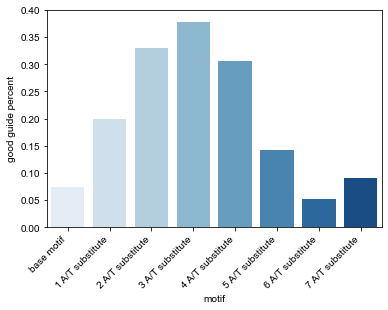

In [11]:
# good guide percentage in base motif and 1-7 A/T sub motif
motif_list = [motif_dic,motif_1sub_dic,motif_2sub_dic,motif_3sub_dic,motif_4sub_dic,motif_5sub_dic,motif_6sub_dic,motif_7sub_dic]
goodguide_stats = []
for i in range(8):
    guide_with_good_motif = {} #key: guide, value: list of gene, pos, relative ratio
    for index, row in dataframe.iterrows():
        guide = row['guide'].upper()
        if guide[16:23] in motif_list[i]:
            guide_with_good_motif[row['guide']]=[row['gene'],row['pos'],1-row['relative_ratio'],row['binary_relative_ratio_075f']]
    df_guide_motif = pd.DataFrame.from_dict(guide_with_good_motif, orient='index',columns=['gene', 'pos', 'relative_ratio', 'binary_relative_ratio'])
    goodg = np.count_nonzero(df_guide_motif['binary_relative_ratio'].values)
    if i == 0: #base motif
        goodguide_stats.append(['base motif',goodg/len(df_guide_motif),goodg,len(df_guide_motif)])
    else:
        goodguide_stats.append([(str(i)+' A/T substitute'),goodg/len(df_guide_motif),goodg,len(df_guide_motif)])

goodguide_stats_df_all = pd.DataFrame(goodguide_stats, columns = ['motif', 'good guide percent','good guide number','total guide number'])
#goodguide_stats_df_all.to_csv('nmer_results/a_enrich_motif_sub_goodg_stats.csv',index=False)    
h = sns.barplot(x='motif',y='good guide percent',data=goodguide_stats_df_all,ci=None,palette="Blues")
h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylim(0,0.4)
plt.savefig(fname='../a_figures/motif_substitution.svg')

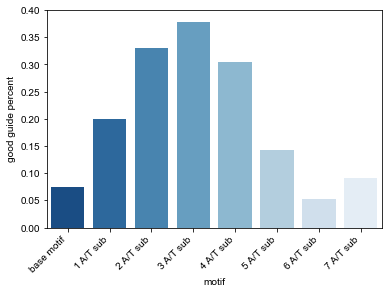

In [15]:
# remove AA/TT in the sub motif
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

sub_motif_list = [motif_1sub_dic,motif_2sub_dic,motif_3sub_dic,motif_4sub_dic,motif_5sub_dic,motif_6sub_dic,motif_7sub_dic]
sub_motif_list_no_di_at = [motif_dic]
for mm in sub_motif_list:
    for sub_motif in list(mm.keys()):
        if ('AA' in sub_motif) or ('TT' in sub_motif):
            mm.pop(sub_motif)
    #print(len(mm))
    sub_motif_list_no_di_at.append(mm)
    
goodguide_stats = []
for i in range(8):
    guide_with_good_motif_sub = {} #key: guide, value: list of gene, pos, relative ratio
    for index, row in dataframe.iterrows():
        guide = row['guide'].upper()
        if guide[16:23] in sub_motif_list_no_di_at[i]:
            guide_with_good_motif_sub[row['guide']]=[row['gene'],row['pos'],1-row['relative_ratio'],row['binary_relative_ratio_075f']]
    df_guide_motif = pd.DataFrame.from_dict(guide_with_good_motif_sub, orient='index',columns=['gene', 'pos', 'relative_ratio', 'binary_relative_ratio'])
    goodg = np.count_nonzero(df_guide_motif['binary_relative_ratio'].values)
    if i == 0: #base motif
        goodguide_stats.append(['base motif',goodg/len(df_guide_motif),goodg,len(df_guide_motif)])
    else:
        goodguide_stats.append([(str(i)+' A/T sub'),goodg/len(df_guide_motif),goodg,len(df_guide_motif)])
    #goodguide_stats.append([(str(i+1)+' A/T substitute'),goodg/len(df_guide_motif),goodg,len(guide_with_good_motif_sub)])

goodguide_stats_df_all = pd.DataFrame(goodguide_stats, columns = ['motif', 'good guide percent','good guide number','total guide number'])
#goodguide_stats_df_all.to_csv('nmer_results/a_enrich_motif_sub_nodi_at_goodg_stats.csv',index=False)    
h = sns.barplot(x='motif',y='good guide percent',data=goodguide_stats_df_all,ci=None,palette="Blues_r")
h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylim(0,0.4)
plt.savefig(fname='../a_figures/motif_substitution_no_di_at.svg')

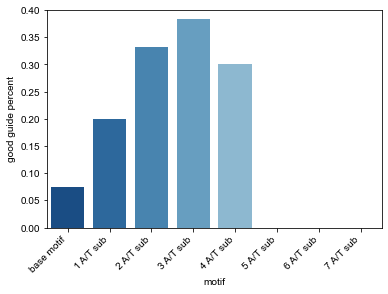

In [9]:
# remove AA/TT/TA/AT in the sub motif
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

sub_motif_list = [motif_1sub_dic,motif_2sub_dic,motif_3sub_dic,motif_4sub_dic,motif_5sub_dic,motif_6sub_dic,motif_7sub_dic]
sub_motif_list_no_at_neighboring = [motif_dic]
for mm in sub_motif_list:
    for sub_motif in list(mm.keys()):
        if ('AA' in sub_motif) or ('TT' in sub_motif) or ('TA' in sub_motif) or ('AT' in sub_motif):
            mm.pop(sub_motif)
    #print(len(mm))
    sub_motif_list_no_at_neighboring.append(mm)
    
goodguide_stats = []
for i in range(8):
    guide_with_good_motif_sub = {} #key: guide, value: list of gene, pos, relative ratio, binary relative ratio
    for index, row in dataframe.iterrows():
        guide = row['guide'].upper()
        if guide[16:23] in sub_motif_list_no_at_neighboring[i]:
            guide_with_good_motif_sub[row['guide']]=[row['gene'],row['pos'],1-row['relative_ratio'],row['binary_relative_ratio_075f']]
    df_guide_motif = pd.DataFrame.from_dict(guide_with_good_motif_sub, orient='index',columns=['gene', 'pos', 'relative_ratio', 'binary_relative_ratio'])
    goodg = np.count_nonzero(df_guide_motif['binary_relative_ratio'].values)
    if i == 0: #base motif
        goodguide_stats.append(['base motif',goodg/len(df_guide_motif),goodg,len(df_guide_motif)])
    elif len(df_guide_motif)!= 0:
        goodguide_stats.append([(str(i)+' A/T sub'),goodg/len(df_guide_motif),goodg,len(df_guide_motif)])
    else: # no guides with the motif
        goodguide_stats.append([(str(i)+' A/T sub'),0,0,0])
    #goodguide_stats.append([(str(i+1)+' A/T substitute'),goodg/len(df_guide_motif),goodg,len(guide_with_good_motif_sub)])

goodguide_stats_df_all = pd.DataFrame(goodguide_stats, columns = ['motif', 'good guide percent','good guide number','total guide number'])
#goodguide_stats_df_all.to_csv('nmer_results/a_enrich_motif_sub_nodi_at_goodg_stats.csv',index=False)    
h = sns.barplot(x='motif',y='good guide percent',data=goodguide_stats_df_all,ci=None,palette="Blues_r")
h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylim(0,0.4)
plt.savefig(fname='../a_figures/motif_substitution_no_at_neighboring.svg')

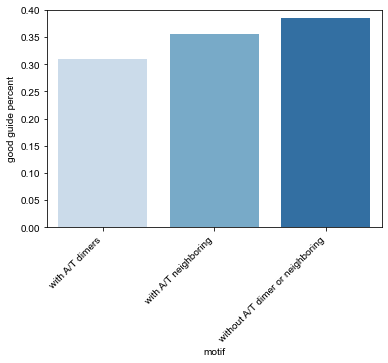

In [10]:
# compare AT dimer, AT neiboring and the rest in 3 A/T sub motifs
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

at_dimer = []
at_neighboring = []
no_at_di_nei = []
for sub_motif in motif_3sub_dic.keys():
    flag_at = 0  # whether the motif has A/T dimer or neighboring
    if ('AA' in sub_motif) or ('TT' in sub_motif):
        at_dimer.append(sub_motif)
        flag_at = 1
    if ('TA' in sub_motif) or ('AT' in sub_motif):
        at_neighboring.append(sub_motif)
        flag_at = 1
    if flag_at == 0:
        no_at_di_nei.append(sub_motif)
        
motif_list = [at_dimer,at_neighboring,no_at_di_nei]
motif_names = ['with A/T dimers', 'with A/T neighboring','without A/T dimer or neighboring']
goodguide_stats = []
for i in range(3):
    motif_class = motif_list[i]
    guide_with_good_motif_sub = {} #key: guide, value: list of gene, pos, relative ratio
    for index, row in dataframe.iterrows():
        guide = row['guide'].upper()
        if guide[16:23] in motif_class:
            guide_with_good_motif_sub[row['guide']]=[row['gene'],row['pos'],1-row['relative_ratio'],row['binary_relative_ratio_075f']]
    df_guide_motif = pd.DataFrame.from_dict(guide_with_good_motif_sub, orient='index',columns=['gene', 'pos', 'relative_ratio', 'binary_relative_ratio'])
    goodg = np.count_nonzero(df_guide_motif['binary_relative_ratio'].values)

    goodguide_stats.append([motif_names[i],goodg/len(df_guide_motif),goodg,len(df_guide_motif)])
    #goodguide_stats.append([(str(i+1)+' A/T substitute'),goodg/len(df_guide_motif),goodg,len(guide_with_good_motif_sub)])

goodguide_stats_df_all = pd.DataFrame(goodguide_stats, columns = ['motif', 'good guide percent','good guide number','total guide number'])
#goodguide_stats_df_all.to_csv('nmer_results/a_enrich_motif_sub_nodi_at_goodg_stats.csv',index=False)    
h = sns.barplot(x='motif',y='good guide percent',data=goodguide_stats_df_all,ci=None,palette="Blues")
h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylim(0,0.4)
plt.savefig(fname='../a_figures/motif_substitution_3_sub_compare.svg')

## depleted motif

In [9]:
# final motif: 16 T, 17 T, 18 T/A, 19 T, 20 G, 21 G, 22 T/A, 23 A
motif_dic = {}
p18=p22=['T','A']
p16=p17=p19=['T']
p20=p21=['G']
p23=['A']
for b16 in p16:
    for b17 in p17:
        for b18 in p18:
            for b19 in p19:
                for b20 in p20:
                    for b21 in p21:
                        for b22 in p22:
                            for b23 in p23:
                                motif = b16+b17+b18+b19+b20+b21+b22+b23
                                motif_dic[motif] = motif
print(len(motif_dic))           

guide_with_good_motif = {} #key: guide, value: list of gene, pos, relative ratio
for index, row in dataframe.iterrows():
    guide = row['guide'].upper()
    if guide[15:23] in motif_dic:
        guide_with_good_motif[row['guide']]=[row['gene'],row['pos'],1-row['relative_ratio'],row['binary_relative_ratio_075f']]

df_guide_motif = pd.DataFrame.from_dict(guide_with_good_motif, orient='index',columns=['gene', 'pos', 'relative_ratio', 'binary_relative_ratio'])
#df_guide_motif['binary_relative_ratio'].values
goodg = np.count_nonzero(df_guide_motif['binary_relative_ratio'].values)
print(len(df_guide_motif))
print(goodg)
print(goodg/len(df_guide_motif))

4
11
0
0.0


In [11]:
#substitution
# 1 to 2 A/T substitute at P20, 21 on the basic motif
motif_1sub_dic = {}
motif_2sub_dic = {}

#sub 1
for m in motif_dic.keys():
    for i in [4,5]: #pos20,21
        ms1 = list(m)
        ms1[i] = 'A'
        ms1 = "".join(ms1)
        motif_1sub_dic[ms1]=ms1
        ms2 = list(m)
        ms2[i] = 'T'
        ms2 = "".join(ms2)
        motif_1sub_dic[ms2]=ms2
            
print(len(motif_1sub_dic))

#sub 2
for m in motif_dic.keys():    
    ms1 = list(m)
    ms1[4] = 'A'
    ms1[5] = 'A'
    ms1 = "".join(ms1)
    motif_2sub_dic[ms1]=ms1
    ms2 = list(m)
    ms2[4] = 'A'
    ms2[5] = 'T'
    ms2 = "".join(ms2)
    motif_2sub_dic[ms2]=ms2
    ms3 = list(m)
    ms3[4] = 'T'
    ms3[5] = 'A'
    ms3 = "".join(ms3)
    motif_2sub_dic[ms3]=ms3
    ms4 = list(m)
    ms4[4] = 'T'
    ms4[5] = 'T'
    ms4 = "".join(ms4)
    motif_2sub_dic[ms4]=ms4
        
print(len(motif_2sub_dic))

# good guide percentage in 1-2 A/T sub motif
sub_motif_list = [motif_1sub_dic,motif_2sub_dic]
goodguide_stats = []
for i in range(2):
    guide_with_good_motif_sub = {} #key: guide, value: list of gene, pos, relative ratio
    for index, row in dataframe.iterrows():
        guide = row['guide'].upper()
        if guide[15:23] in sub_motif_list[i]:
            guide_with_good_motif_sub[row['guide']]=[row['gene'],row['pos'],1-row['relative_ratio'],row['binary_relative_ratio_075f']]
    df_guide_motif = pd.DataFrame.from_dict(guide_with_good_motif_sub, orient='index',columns=['gene', 'pos', 'relative_ratio', 'binary_relative_ratio'])
    goodg = np.count_nonzero(df_guide_motif['binary_relative_ratio'].values)
    goodguide_stats.append([(str(i+1)+' A/T substitute'),goodg/len(df_guide_motif),goodg,len(guide_with_good_motif_sub)])

goodguide_stats_df_all = pd.DataFrame(goodguide_stats, columns = ['sub_num', 'good guide percent','good guide number','total guide number'])
goodguide_stats_df_all.to_csv('../nmer_results/a_depleted_motif_sub_goodg_stats.csv',index=False) 

16
16


## good guide percent in feature bins

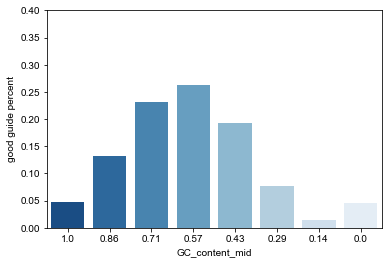

In [17]:
#fig, ax = plt.subplots(5,3,figsize=(12,15),constrained_layout=True)
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
fig = plt.figure()
ax = fig.add_subplot(111) 

#dataframe['GC_mid_bins'] = pd.cut(dataframe['GC_content_mid'],bins=8)
#dataframe['GC_mid_bins'] = dataframe['GC_mid_bins'].map(lambda x : round(x.left,3))
dataframe['GC_content_mid'] = dataframe['GC_content_mid'].map(lambda x : round(x,2))
sns.barplot(x='GC_content_mid', y='binary_relative_ratio_075f', data=dataframe,ci=None,
          palette="Blues")
plt.ylim(0,0.4)
plt.ylabel('good guide percent')
ax.invert_xaxis()

#for label in ax[px,py].xaxis.get_ticklabels()[::2]:
#    label.set_visible(False)
plt.savefig(fname='../a_figures/motif_gc_content.svg')